In [3]:
import ee
ee.Authenticate()
ee.Initialize()

# Air Pollution in Addis Ababa

This notebook analyses air pollution in Addis Ababa from 2019 till 2024. This is an ongoing methodology to understand economic activity using air pollution. This notebook does an exploratory analysis of the data and overlays the data with road networks to see the difference in pollution closer to major roads. 

## Methodology

- Extract Air Pollution data from Google Earth Engine
- Plot it at a national level
- Plot it at a woredas
- Overlay road networks with air pollution
- Estimate pollution closer to roads and farther away from it

## Insights

In [1]:
import geopandas as gpd
import pandas as pd

from shapely.geometry import Point
from datetime import datetime
import ee

from bokeh.models import Tabs, TabPanel
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.plotting import show, output_notebook
import bokeh

import acled_conflict_analysis
from acled_conflict_analysis import analysis
from acled_conflict_analysis import visuals
import geemap



In [2]:
addis = gpd.read_file('../../data/boundaries/eth_admbnda_adm1_csa_bofedb_2021.shp')
addis = addis[addis['ADM1_EN']=='Addis Ababa']

In [3]:
air_pollution = pd.concat([pd.read_csv('../../data/air_pollution/no2_addis_20190101_20191231.csv'),
                            pd.read_csv('../../data/air_pollution/no2_addis_20200101_20201231.csv'),
                            pd.read_csv('../../data/air_pollution/no2_addis_20210101_20211231.csv'),
                            pd.read_csv('../../data/air_pollution/no2_addis_20220101_20221231.csv'),
                            pd.read_csv('../../data/air_pollution/no2_addis_20230101_20231231.csv'),
                            pd.read_csv('../../data/air_pollution/no2_addis_20240101_20241015.csv')

])

In [4]:
air_pollution['date'] = pd.to_datetime(air_pollution['date'])

air_pollution.drop(columns = 'Unnamed: 0', inplace=True)
air_pollution['aoi'] = 'Addis Ababa'
air_pollution.rename(columns = {'date':'event_date'}, inplace=True)

### Monthly National Pollution

In [31]:
from bokeh.io import output_notebook, show
from bokeh.models import Span
import pandas as pd
from bokeh.plotting import figure

output_notebook()

# Grouping and calculating the monthly mean by aoi
df = air_pollution.groupby([pd.Grouper(key='event_date', freq='MS'), 'aoi'])['NO2'].mean().reset_index()

# Group by year and calculate the yearly average NO2
df['year'] = pd.DatetimeIndex(df['event_date']).year
yearly_avg = df.groupby('year')['NO2'].mean().reset_index()

# Get the line plot for monthly NO2
p = visuals.get_line_plot(
    df,
    "Monthly Air Pollution in Addis Ababa",
    "Source: Sentinel 5-P extracted from Google Earth Engine",
    subtitle = "",
    category = 'aoi',
    measure='NO2'
)

# Add a line for yearly averages
# Assuming you have a way to map the 'year' values to a datetime format for the x-axis in the plot
p.children[1].line(x=pd.to_datetime(yearly_avg['year'], format='%Y'), y=yearly_avg['NO2'], 
       line_width=2, color='red', legend_label='Yearly Average NO2')

# Show the plot with both the monthly and yearly average lines
show(p)


Loading BokehJS ...

**Addis Ababa gets more polluted towards the end of the year in the winters. The summer months are the least polluted with NO2.** This is an expected trend because pollution stays in the air for longer in the winters.This also results in higher particulate matter during the winters. However, the average value per year peaked in 2021 and fell after that. 2019 winter was also unexpectedly less polluted. The reasons for the peak in 2021 and dip in 2019 are yet unknown. 

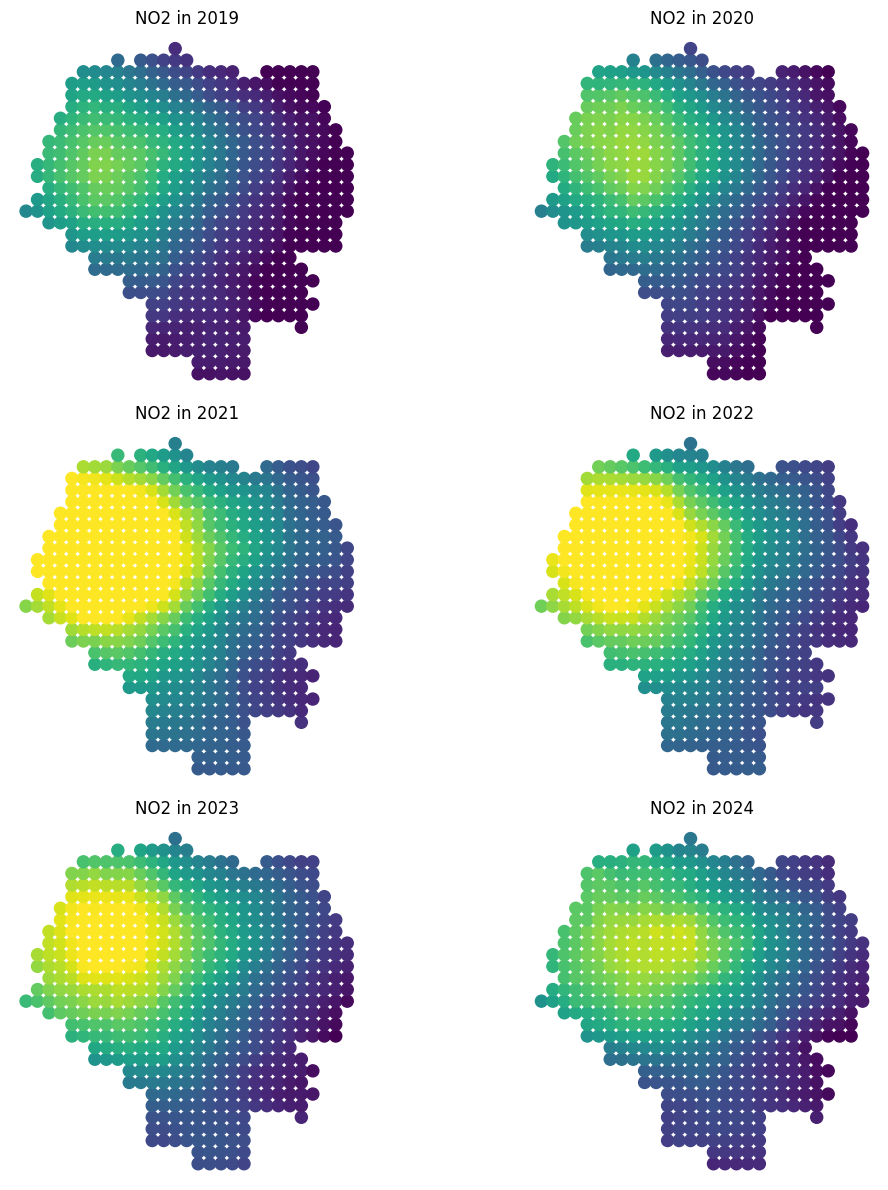

In [33]:
import matplotlib.pyplot as plt

# List of years you want to plot
years = [2019, 2020, 2021, 2022, 2023, 2024]  # You can extend this to more years if needed

# Create a 2x2 grid for the plots
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array to make it easier to index
ax = ax.flatten()

vmin = air_pollution.groupby(['aoi', 'latitude', 'longitude'])[['NO2']].mean().reset_index()['NO2'].min()
vmax = air_pollution.groupby(['aoi', 'latitude', 'longitude'])[['NO2']].mean().reset_index()['NO2'].max()

# Loop through each year and create a plot in a 2x2 grid
for i, year in enumerate(years):
    
    # Create the start and end date for each year dynamically
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter and group the data by latitude and longitude for the given year
    df = air_pollution[(air_pollution['event_date'] >= start_date) & (air_pollution['event_date'] <= end_date)] \
            .groupby(['latitude', 'longitude'])['NO2'].mean().reset_index()

    # Convert to GeoDataFrame and plot for each year
    analysis.convert_to_gdf(df).plot(column='NO2', ax=ax[i], cmap='viridis', markersize=75, 
                                     vmin=vmin, vmax=vmax)

    # Set the title for each subplot
    ax[i].set_title(f'NO2 in {year}')
    
    # Remove the spines, ticks, and grid for a clean look
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].grid(False)

# Automatically adjust the layout so the plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

**The northeastern parts of Addis are the most polluted compared to the rest across years.** COVID years were unexepctedly more polluted than others. 

In [37]:
air_pollution['weekday'] = air_pollution['event_date'].dt.weekday

In [38]:
def get_weekday_group(weekday):
    if weekday<5:
        return 'weekday'
    else:
        return 'weekend'


In [39]:
air_pollution['week_group'] = air_pollution['weekday'].apply(lambda x: get_weekday_group(x))

<Axes: xlabel='NO2', ylabel='Count'>

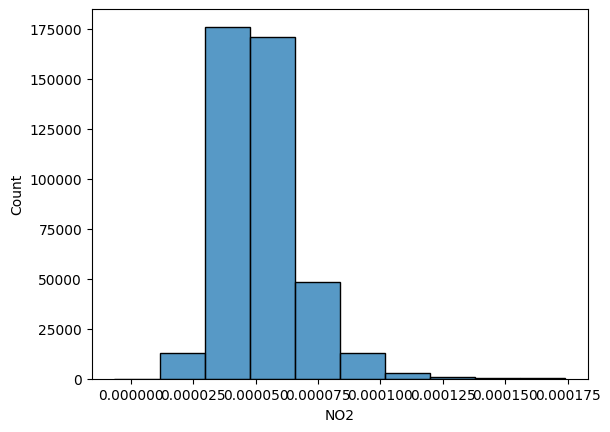

In [40]:
import seaborn as sns 

sns.histplot(air_pollution[air_pollution['event_date']<'2021-01-01']['NO2'], bins=10, edgecolor='black')

**NO2 Vertical Column Density (VCD) typically follows a log normal distribution.** Given this is a case we apply a logarithmic transformation to the data to normalize it. 

In [41]:
# import numpy as np

# constant = 1e-6
# air_pollution.loc[:,'NO2_log_shift'] = air_pollution['NO2'] + constant
# air_pollution['NO2_scaled'] = air_pollution['NO2_log_shift']*1e6
# air_pollution.loc[:,'NO2_log'] = np.log1p(air_pollution['NO2'])

# weekends.loc[:,'NO2_log_shift'] = weekends['NO2'] + constant
# weekends['NO2_scaled'] = weekends['NO2_log_shift']*1e6
# weekends.loc[:,'NO2_log'] = np.log1p(weekends['NO2'])

# weekdays.loc[:,'NO2_log_shift'] = weekdays['NO2'] + constant
# weekdays['NO2_scaled'] = weekdays['NO2_log_shift']*1e6
# weekdays.loc[:,'NO2_log'] = np.log1p(weekdays['NO2'])


In [42]:
ethiopia_adm2 = gpd.read_file('../../data/boundaries/eth_admbnda_adm2_csa_bofedb_2021.shp')
ethiopia_adm3 = gpd.read_file('../../data/boundaries/eth_admbnda_adm3_csa_bofedb_2021.shp')

In [43]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Example: Load your points (these are the center points of the 1.1 km boxes)
# Replace this with your actual points GeoDataFrame
points = analysis.convert_to_gdf(air_pollution[['latitude', 'longitude']].drop_duplicates())

# Step 1: Reproject to a local UTM projection to work in meters
points_utm = points.to_crs(epsg=32633)  # Adjust UTM zone based on your region

# Step 2: Create 1.1 km x 1.1 km boxes around each center point
cell_size = 1100  # 1.1 km in meters
half_size = cell_size / 2

def create_box_around_point(point, half_size):
    """Create a 1.1 km x 1.1 km box (Polygon) around a point."""
    x, y = point.x, point.y
    return Polygon([(x - half_size, y - half_size), 
                    (x + half_size, y - half_size), 
                    (x + half_size, y + half_size), 
                    (x - half_size, y + half_size)])

# Apply the function to create boxes around each point
boxes = points_utm['geometry'].apply(lambda point: create_box_around_point(point, half_size))

# Step 3: Create a new GeoDataFrame with the boxes
boxes_gdf = gpd.GeoDataFrame(geometry=boxes, crs=points_utm.crs)

# Step 4: Reproject back to WGS84 if needed (optional)
boxes_wgs84 = boxes_gdf.to_crs(epsg=4326)

# Step 5: Plot the boxes (optional)
# ax = boxes_wgs84.plot(edgecolor='black', facecolor='none', figsize=(10, 10))
# points.plot(ax=ax, color='red')  # Plot original center points

# Show the plot
# import matplotlib.pyplot as plt
# plt.show()

# Save the boxes to a shapefile or GeoJSON (optional)
# boxes_wgs84.to_file("boxes_1_1km.shp")


In [44]:
points_with_boxes = gpd.sjoin(points_utm, boxes_gdf, how='left', predicate='within')

In [45]:
points_with_boxes.drop(columns='index_right', inplace=True)

In [46]:
df = analysis.convert_to_gdf(air_pollution)

print("air_pollution CRS:", df.crs)
print("boxes_wgs84 CRS:", boxes_wgs84.crs)

air_pollution_adm3 = gpd.sjoin(boxes_wgs84, df)

air_pollution CRS: EPSG:4326
boxes_wgs84 CRS: EPSG:4326


In [47]:
air_pollution_adm3.drop(columns='index_right', inplace=True)

In [48]:
air_pollution_adm3_all = ethiopia_adm3[ethiopia_adm3['ADM1_EN']=='Addis Ababa'].sjoin(air_pollution_adm3)

In [49]:
pollution_monthly_adm3 = air_pollution_adm3_all.groupby(['ADM3_EN', pd.Grouper(key='event_date', freq='MS')])['NO2'].mean().reset_index()
pollution_yearly_adm3 = air_pollution_adm3_all.groupby(['ADM3_EN', pd.Grouper(key='event_date', freq='YS')])['NO2'].mean().reset_index()

pollution_all_adm3 = ethiopia_adm3[['ADM3_EN', 'geometry']].merge(air_pollution_adm3_all.groupby(['ADM3_EN'])['NO2'].mean().reset_index())

### Pollution by woredas in Addis

In [50]:
pollution_all_adm3.explore(column='NO2')

In [51]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Legend, Span, Label
from bokeh.layouts import column
from bokeh.core.validation import silence
from bokeh.core.validation.warnings import EMPTY_LAYOUT
import folium
from folium.plugins import TimestampedGeoJson
import pandas as pd
import importlib.resources as pkg_resources

color_palette = [
    "#002244",  # Blue
    "#F05023",  # Orange
    "#2EB1C2",  # Red
    "#009CA7",  # Teal
    "#00AB51",  # Green
    "#FDB714",  # Yellow
    "#872B90",  # Purple
    "#F78D28",  # Light Orange
    "#00A996",  # Teal-Ish Green
    "#A6192E",  # Dark Red
    "#004C97",  # Navy Blue
    "#FFD100",  # Bright Yellow
    "#7A5195",  # Lavender Purple
    "#EF5675",  # Coral Red
    "#955196",  # Light Purple
    "#003F5C",  # Dark Navy
    "#FFA600",  # Bright Orange
    "#58B947",  # Lime Green
    "#8D230F",  # Brick Red
    "#FFB400",  # Gold
    "#24693D",  # Forest Green
    "#CC2525",  # Bright Red
    "#6A4C93",  # Violet
    "#1C3144",  # Dark Slate Blue
    "#C7EFCF",  # Mint Green
]

def get_line_plot(
    dataframe,
    title,
    source,
    subtitle=None,
    measure="conflictIndex",
    category="DT",
    event_date="event_date",
    events_dict=None
):
    p2 = figure(x_axis_type="datetime", width=800, height=500, toolbar_location="above")

    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(dataframe[category].unique()):
        df = dataframe[dataframe[category] == adm2][
            [event_date, measure]
        ].reset_index(drop=True)
        p2.line(
            df[event_date],
            df[measure],
            line_width=2,
            line_color=color_palette[id],
            legend_label=adm2,
        )

    p2.legend.click_policy = "hide"
    if subtitle is not None:
        p2.title = subtitle

    title_fig = figure(
        title=title,
        toolbar_location=None,
        width=800,
        height=40,
    )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "14pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width = 0

    # with silence(MISSING_RENDERERS):
    sub_title = figure(
        title=source,
        toolbar_location=None,
        width=800,
        height=40,
    )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style = "normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width = 0

    if events_dict:

        used_y_positions = []

            
        for index, (event_date, label) in enumerate(events_dict.items()):
            span = Span(
                location=event_date,
                dimension="height",
                line_color='#C6C6C6',
                line_width=2,
                line_dash=(4, 4)
            )
            p2.renderers.append(span)

            # Determine a base y position
            base_y = max(dataframe[measure])  # Adjust for visibility above the plot
            # Find an appropriate y position that doesn't overlap
            y_position = base_y  # Default position

            # Adjust y_position if it overlaps with previous labels
            while y_position in used_y_positions:
                y_position -= max(dataframe[measure])/20  # Move down until it's free

            used_y_positions.append(y_position)  # Store the used position

            event_label = Label(
                x=event_date,
                y=y_position,
                text=label,
                text_color="black",
                text_font_size="10pt",
                background_fill_color="grey",
                background_fill_alpha=0.2,
            )
            p2.add_layout(event_label)

    layout = column(title_fig, p2, sub_title)


    return layout

In [52]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = ["Monthly Air Pollution"]

tabs.append(
    TabPanel(
        child=get_line_plot(
            pollution_yearly_adm3,
            f"Yearly air pollution by province",
            f"Source: Sentinel-5P. Accessed {datetime.today().date().isoformat()}",
            subtitle="",
            category="ADM3_EN",
            measure='NO2',
        ),
        #title=type.capitalize(),
    )
)

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [53]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []
titles = ["Monthly Air Pollution"]

tabs.append(
    TabPanel(
        child=get_line_plot(
            pollution_monthly_adm3,
            f"Monthly air pollution by province",
            f"Source: Sentinel-5P. Accessed {datetime.today().date().isoformat()}",
            subtitle="",
            category="ADM3_EN",
            measure='NO2',
        ),
        #title=type.capitalize(),
    )
)

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [6]:
roads = gpd.read_file('../../data/roads/addis_primary_roads.shp')

### Daily Shifts in Air Pollution

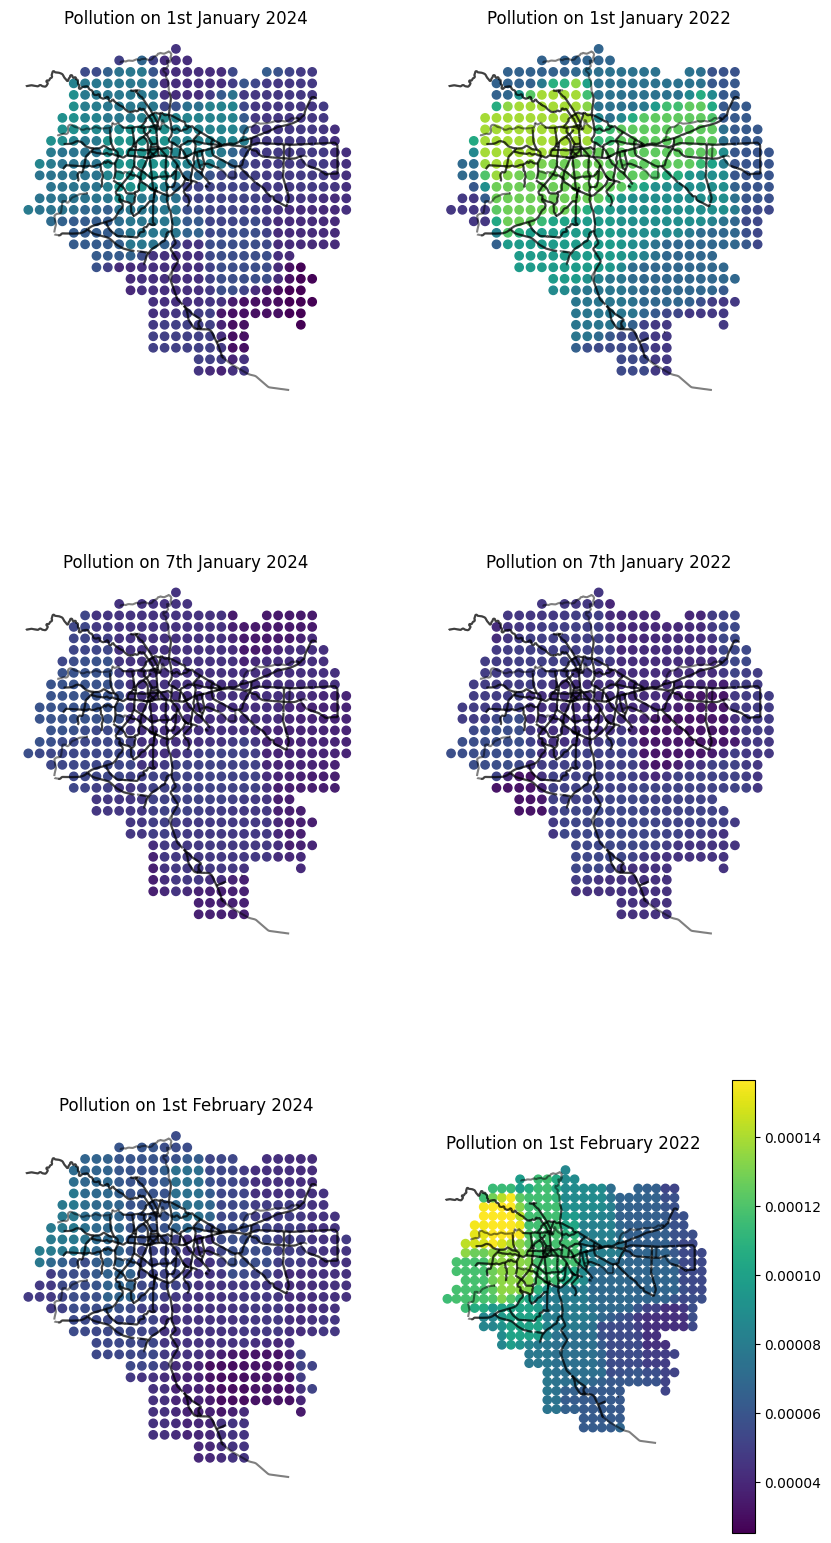

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'event_date' is a datetime64 column, cast the comparison values to datetime
date_filter = pd.to_datetime(['2022-01-01', '2022-01-07', '2024-01-01', '2024-01-07', '2024-02-01', '2022-02-01'])

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(10, 20))
ax=axs.flatten()
gdf = analysis.convert_to_gdf(air_pollution)

# First plot: Pollution on 1st January 2024
roads.plot(ax=ax[0], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2024-01-01')].plot(
    column='NO2', 
    ax=ax[0], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max()
)
ax[0].set_title('Pollution on 1st January 2024')
ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].spines[:].set_visible(False); ax[0].grid(False)

# Second plot: Pollution on 1st February 2024
roads.plot(ax=ax[1], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2022-01-01')].plot(
    column='NO2', 
    ax=ax[1], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max()
)
ax[1].set_title('Pollution on 1st January 2022')
ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].spines[:].set_visible(False); ax[1].grid(False)

# First plot: Pollution on 25th December 2023
roads.plot(ax=ax[2], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2024-01-07')].plot(
    column='NO2', 
    ax=ax[2], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max()
)
ax[2].set_title('Pollution on 7th January 2024')
ax[2].set_xticks([]); ax[2].set_yticks([]); ax[2].spines[:].set_visible(False); ax[2].grid(False)

# Second plot: Pollution on 1st May 2024
roads.plot(ax=ax[3], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2022-01-07')].plot(
    column='NO2', 
    ax=ax[3], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max()
)
ax[3].set_title('Pollution on 7th January 2022')
ax[3].set_xticks([]); ax[3].set_yticks([]); ax[3].spines[:].set_visible(False); ax[3].grid(False)

roads.plot(ax=ax[4], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2024-02-01')].plot(
    column='NO2', 
    ax=ax[4], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max()
)
ax[4].set_title('Pollution on 1st February 2024')
ax[4].set_xticks([]); ax[4].set_yticks([]); ax[4].spines[:].set_visible(False); ax[4].grid(False)

# Second plot: Pollution on 1st May 2024
roads.plot(ax=ax[5], color='black', alpha=0.5)
gdf[gdf['event_date'] == pd.to_datetime('2022-02-01')].plot(
    column='NO2', 
    ax=ax[5], 
    vmin=gdf[gdf['event_date'].isin(date_filter)]['NO2'].min(), 
    vmax=gdf[gdf['event_date'].isin(date_filter)]['NO2'].max(), legend=True
)
ax[5].set_title('Pollution on 1st February 2022')
ax[5].set_xticks([]); ax[5].set_yticks([]); ax[5].spines[:].set_visible(False); ax[5].grid(False)

plt.show()


**Christmas day seems less polluted tha New Years day both in 2024 and 2022.** However, 2022 was more polluted than 2024. 

### Weekdays vs Weekends

In [77]:
df = air_pollution.groupby(['latitude', 'longitude', 'week_group', pd.Grouper(key='event_date', freq='YS')])['NO2'].mean().reset_index()
weekdays = df[df['week_group']=='weekday']
weekends = df[df['week_group']=='weekend']

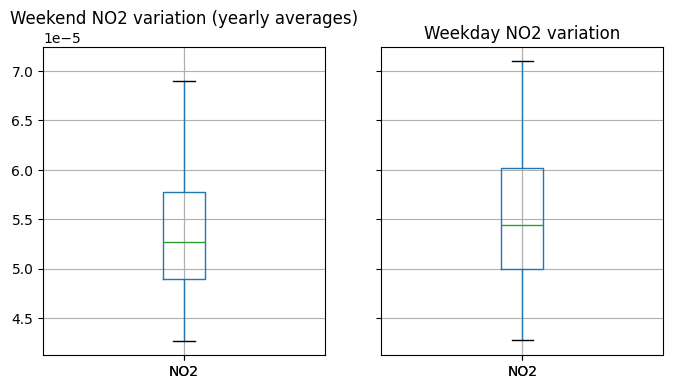

In [80]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
weekends[['NO2']].boxplot(ax=ax[0])
ax[0].set_title('Weekend NO2 variation (yearly averages)')
weekdays[['NO2']].boxplot(ax=ax[1])
ax[1].set_title('Weekday NO2 variation');

**Comparing weekday and weekend average pollution shows that when you average all the weekdays in a year across 2019-2024, the air pollution is higher on weekdays than weekends**

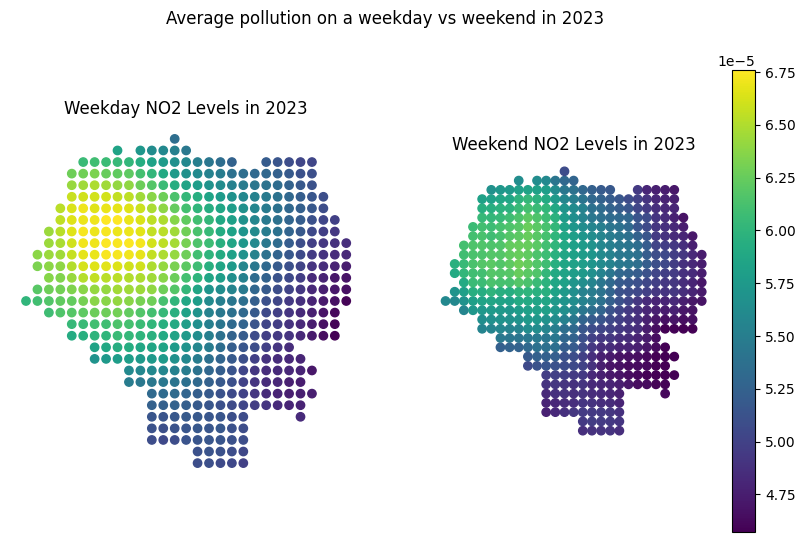

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,6))
analysis.convert_to_gdf(weekdays[weekdays['event_date']=='2023-01-01']).plot(column='NO2', ax=ax[0], 
        vmin=weekdays[weekdays['event_date']=='2023-01-01']['NO2'].min(), vmax = weekdays[weekdays['event_date']=='2023-01-01']['NO2'].max())
ax[0].set_title('Weekday NO2 Levels in 2023')

ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].spines[:].set_visible(False); ax[0].grid(False)

analysis.convert_to_gdf(weekends[weekends['event_date']=='2023-01-01']).plot(column='NO2', ax=ax[1], 
        vmin=weekdays[weekdays['event_date']=='2023-01-01']['NO2'].min(), 
        vmax = weekdays[weekdays['event_date']=='2023-01-01']['NO2'].max(),
        legend=True)
ax[1].set_title('Weekend NO2 Levels in 2023')
ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].spines[:].set_visible(False); ax[1].grid(False)

plt.suptitle('Average pollution on a weekday vs weekend in 2023');

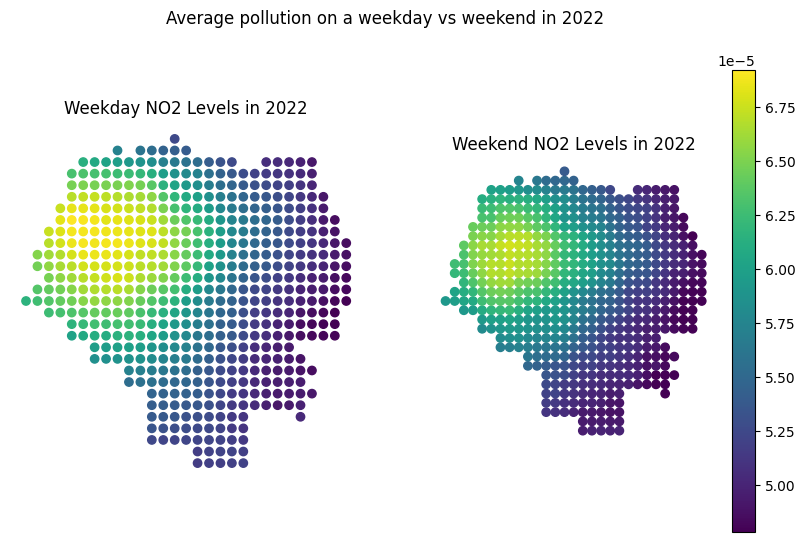

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,6))
analysis.convert_to_gdf(weekdays[weekdays['event_date']=='2022-01-01']).plot(column='NO2', ax=ax[0], 
                        vmin=weekdays[weekdays['event_date']=='2022-01-01']['NO2'].min(), 
                        vmax = weekdays[weekdays['event_date']=='2022-01-01']['NO2'].max())
ax[0].set_title('Weekday NO2 Levels in 2022')

ax[0].set_xticks([]); ax[0].set_yticks([]); ax[0].spines[:].set_visible(False); ax[0].grid(False)

analysis.convert_to_gdf(weekends[weekends['event_date']=='2022-01-01']).plot(column='NO2', ax=ax[1], 
                        vmin=weekdays[weekdays['event_date']=='2022-01-01']['NO2'].min(), 
                        vmax = weekdays[weekdays['event_date']=='2022-01-01']['NO2'].max(), legend=True)
ax[1].set_title('Weekend NO2 Levels in 2022')
ax[1].set_xticks([]); ax[1].set_yticks([]); ax[1].spines[:].set_visible(False); ax[1].grid(False)

plt.suptitle('Average pollution on a weekday vs weekend in 2022');

In [91]:
boxes_wgs84.to_file('../../data/air_pollution/addis_no2_polygons.shp')